# 1. Imports

In [2]:
import json
import numpy as np
import tensorflow as tf
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


# 2. Load the Data

In [3]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json -O "./data/sarcasm.json"

--2023-11-14 01:13:18--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.16.251, 142.250.187.251, 142.250.180.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.16.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘./data/sarcasm.json’

./data/sarcasm.json 100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2023-11-14 01:13:19 (42.5 MB/s) - ‘./data/sarcasm.json’ saved [5643545/5643545]



In [4]:
with open('./data/sarcasm.json', 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

# 3. Hyperparameters

In [5]:
training_size = 20000
vocab_size = 10000 # vocab size of the tokenizer
max_length = 32 # maximum length of the padded sequence
embedding_dim = 16 # output dimensions of the embedding layer

# 4. Split the dataset

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# 5. Pre-processing

In [7]:
# parameters for padding and OOV (out of vocav) tokens
trunc_type = 'post' # for longer sentences, remove tokens at the end
padding_type = 'post' # for shorter sentences, pad with zeros at the end
oov_tok = "<OOV>" # try to pick a oov token that will not appear in your dataset (hence the use of <>)

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

# 6. Building the Model

In [8]:
# You can think of sequences like one dimensional images. 
# Typically we flatten images before they go to Dense layers, but we will use GlobalAveragePooling1D instead
# This averages over the sequence dimension before connecting to the dense layers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 7. Train the Model

In [22]:
history = model.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/30
625/625 [==============================] - 1s 1ms/step - loss: 0.5668 - accuracy: 0.6913 - val_loss: 0.3963 - val_accuracy: 0.8369
Epoch 2/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3126 - accuracy: 0.8731 - val_loss: 0.3432 - val_accuracy: 0.8563
Epoch 3/30
625/625 [==============================] - 1s 968us/step - loss: 0.2347 - accuracy: 0.9084 - val_loss: 0.3426 - val_accuracy: 0.8571
Epoch 4/30
625/625 [==============================] - 1s 965us/step - loss: 0.1891 - accuracy: 0.9280 - val_loss: 0.3602 - val_accuracy: 0.8539
Epoch 5/30
625/625 [==============================] - 1s 969us/step - loss: 0.1567 - accuracy: 0.9415 - val_loss: 0.3866 - val_accuracy: 0.8524
Epoch 6/30
625/625 [==============================] - 1s 971us/step - loss: 0.1321 - accuracy: 0.9536 - val_loss: 0.4215 - val_accuracy: 0.8477
Epoch 7/30
625/625 [==============================] - 1s 967us/step - loss: 0.1136 - accuracy: 0.9603 - val_loss: 0.4693 - val_accuracy: 0.8

# 8. Visualize the Output

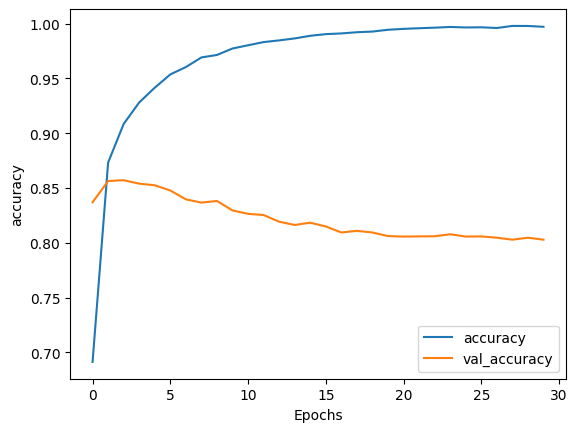

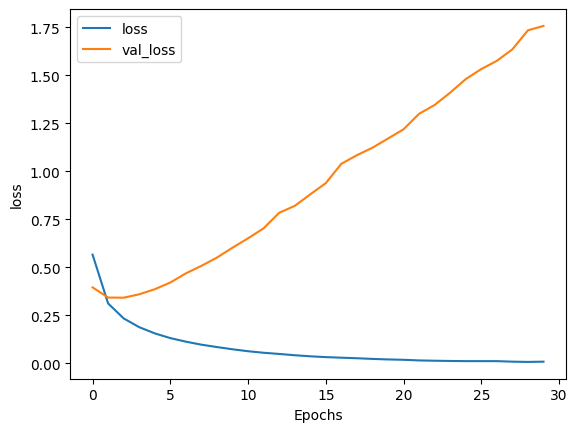

In [23]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# 9. Word Embeddings Shape

In [11]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(10000, 16)
